In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

2025-12-03 13:53:05.958855: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-03 13:53:06.090985: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764744786.135024   10419 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764744786.148097   10419 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764744786.249207   10419 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [5]:
df = pd.read_csv('winequality-white.csv', sep=';')

print(df.head())
print(df.info())
print(df['quality'].value_counts().sort_index())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6 

In [6]:
num_duplicates = df.duplicated().sum()
print(f"Число полных дубликатов: {num_duplicates}")

Число полных дубликатов: 937


In [7]:
df = df.drop_duplicates().reset_index(drop=True)

In [35]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l2

# ======================================================
# 1. ЗАГРУЗКА ДАННЫХ
# ======================================================
df = pd.read_csv('winequality-white.csv', sep=';')  

# Разделение на признаки и целевую переменную
X = df.drop('quality', axis=1)
y = df['quality']

# ======================================================
# 2. МАСШТАБИРОВАНИЕ И РАЗБИЕНИЕ
# ======================================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 60/20/20: train / val / test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42  # 0.25 * 0.8 = 0.2
)

# ======================================================
# 3. ФУНКЦИЯ СОЗДАНИЯ И ОБУЧЕНИЯ МОДЕЛИ
# ======================================================
def create_and_train_model(
    layers_config,
    activation='relu',
    optimizer='adam',
    epochs=100,
    verbose=0,
    l2_reg=1e-4,
    dropout_rate=0.1
):
    model = Sequential()

    # Скрытые слои
    for i, units in enumerate(layers_config):
        if i == 0:
            model.add(
                Dense(
                    units,
                    activation=activation,
                    input_shape=(X_train.shape[1],),
                    kernel_regularizer=l2(l2_reg)
                )
            )
        else:
            model.add(
                Dense(
                    units,
                    activation=activation,
                    kernel_regularizer=l2(l2_reg)
                )
            )
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    # Выходной слой (регрессия)
    model.add(Dense(1, activation='linear'))

    # Оптимизатор
    if optimizer == 'adam':
        opt = Adam(learning_rate=1e-3)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=1e-3)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=1e-2, momentum=0.9)
    else:
        opt = optimizer  # если передали уже готовый оптимизатор

    model.compile(optimizer=opt, loss='mse', metrics=['mae'])

    # Callbacks: ранняя остановка + уменьшение LR
    es = tf.keras.callbacks.EarlyStopping(
        monitor='val_mae',
        patience=15,
        restore_best_weights=True
    )
    rlr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_mae',
        factor=0.5,
        patience=5,
        min_lr=1e-5
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=64,
        verbose=verbose,
        callbacks=[es, rlr]
    )

    # Предсказания и метрики на тесте
    y_pred = model.predict(X_test).flatten()

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return {
        'config': layers_config,
        'activation': activation,
        'optimizer': optimizer,
        'MSE': mse,
        'MAE': mae,
        'R2': r2,
        'history': history,
        'model': model
    }

# ======================================================
# 4. НАБОР КОНФИГУРАЦИЙ ДЛЯ ТЕСТА
# ======================================================
configs = [
    ([64], 'relu', 'adam'),
    ([128], 'relu', 'adam'),
    ([64, 32], 'relu', 'adam'),
    ([128, 64], 'relu', 'adam'),
    ([64, 32], 'tanh', 'adam'),
]

# ======================================================
# 5. ОБУЧЕНИЕ И СБОР РЕЗУЛЬТАТОВ
# ======================================================
results = []

for layers, act, opt in configs:
    print(f"Training: {layers}, activation={act}, optimizer={opt}")
    res = create_and_train_model(
        layers_config=layers,
        activation=act,
        optimizer=opt,
        epochs=200,
        verbose=0
    )
    results.append(res)
    print(f"  → MSE: {res['MSE']:.4f}, MAE: {res['MAE']:.4f}, R2: {res['R2']:.4f}\n")

# ======================================================
# 6. ТАБЛИЦА С РЕЗУЛЬТАТАМИ
# ======================================================
df_results = pd.DataFrame([
    {
        'Architecture': str(r['config']),
        'Activation': r['activation'],
        'Optimizer': r['optimizer'],
        'MSE': round(r['MSE'], 4),
        'MAE': round(r['MAE'], 4),
        'R2': round(r['R2'], 4)
    }
    for r in results
]).sort_values(by='MSE')

print(df_results)


Training: [64], activation=relu, optimizer=adam


/home/verokul/.pyenv/versions/3.11.9/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
  → MSE: 0.4953, MAE: 0.5509, R2: 0.3605

Training: [128], activation=relu, optimizer=adam


/home/verokul/.pyenv/versions/3.11.9/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
  → MSE: 0.4909, MAE: 0.5504, R2: 0.3661

Training: [64, 32], activation=relu, optimizer=adam


/home/verokul/.pyenv/versions/3.11.9/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
  → MSE: 0.5026, MAE: 0.5498, R2: 0.3510

Training: [128, 64], activation=relu, optimizer=adam


/home/verokul/.pyenv/versions/3.11.9/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
  → MSE: 0.4876, MAE: 0.5422, R2: 0.3704

Training: [64, 32], activation=tanh, optimizer=adam


/home/verokul/.pyenv/versions/3.11.9/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
  → MSE: 0.5177, MAE: 0.5717, R2: 0.3316

  Architecture Activation Optimizer     MSE     MAE      R2
3    [128, 64]       relu      adam  0.4876  0.5422  0.3704
1        [128]       relu      adam  0.4909  0.5504  0.3661
0         [64]       relu      adam  0.4953  0.5509  0.3605
2     [64, 32]       relu      adam  0.5026  0.5498  0.3510
4     [64, 32]       tanh      adam  0.5177  0.5717  0.3316


In [38]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# ======================================================
# 1. ЗАГРУЗКА ДАННЫХ
# ======================================================
df = pd.read_csv('winequality-white.csv', sep=';')  

# целевая колонка
target_col = 'quality'   # если имя другое — подставь его сюда

X = df.drop(columns=[target_col])
y = df[target_col]

# ======================================================
# 2. МАСШТАБИРОВАНИЕ ПРИЗНАКОВ
# ======================================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ======================================================
# 3. НОРМАЛИЗАЦИЯ ТАРГЕТА
#    y_norm = (y - mean) / std
# ======================================================
y_mean = y.mean()
y_std = y.std()
y_norm = (y - y_mean) / y_std

# 60/20/20: train / val / test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y_norm, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42  # 0.25 * 0.8 = 0.2
)

# ======================================================
# 4. ЛУЧШАЯ МОДЕЛЬ: [128, 64] relu + Adam
#    + L2, Dropout, EarlyStopping, ReduceLROnPlateau
# ======================================================
def create_and_train_best_model(
    epochs=300,
    verbose=1,
    l2_reg=1e-4,
    dropout_rate=0.1,
    lr=1e-3
):
    # архитектура
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(l2_reg)))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))

    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    # callbacks
    es = tf.keras.callbacks.EarlyStopping(
        monitor='val_mae',
        patience=20,
        restore_best_weights=True
    )
    rlr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_mae',
        factor=0.5,
        patience=7,
        min_lr=1e-5
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=64,
        verbose=verbose,
        callbacks=[es, rlr]
    )

    # --------------------------------------------------
    # 5. ОЦЕНКА МОДЕЛИ (ДЕНОРМАЛИЗАЦИЯ y)
    # --------------------------------------------------
    y_pred_norm = model.predict(X_test).flatten()

    # возвращаемся к исходной шкале качества
    y_pred = y_pred_norm * y_std + y_mean
    y_test_real = y_test * y_std + y_mean

    mse = mean_squared_error(y_test_real, y_pred)
    mae = mean_absolute_error(y_test_real, y_pred)
    r2 = r2_score(y_test_real, y_pred)

    print(f"BEST MODEL → MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

    return {
        'model': model,
        'history': history,
        'mse': mse,
        'mae': mae,
        'r2': r2,
        'y_pred': y_pred,
        'y_test_real': y_test_real
    }

# ======================================================
# 6. ЗАПУСК ОБУЧЕНИЯ ЛУЧШЕЙ МОДЕЛИ
# ======================================================
result = create_and_train_best_model(
    epochs=300,
    verbose=1,
    l2_reg=1e-4,
    dropout_rate=0.1,
    lr=1e-3
)


Epoch 1/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8146 - mae: 0.6911 - val_loss: 0.6186 - val_mae: 0.6008 - learning_rate: 0.0010
Epoch 2/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7143 - mae: 0.6491 - val_loss: 0.5882 - val_mae: 0.5862 - learning_rate: 0.0010
Epoch 3/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6906 - mae: 0.6382 - val_loss: 0.5764 - val_mae: 0.5822 - learning_rate: 0.0010
Epoch 4/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6703 - mae: 0.6292 - val_loss: 0.5778 - val_mae: 0.5803 - learning_rate: 0.0010
Epoch 5/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6657 - mae: 0.6289 - val_loss: 0.5605 - val_mae: 0.5725 - learning_rate: 0.0010
Epoch 6/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6452 - mae: 0.6189 - val_loss: 0.5599 - val_mae: 0.5750 - learning_rate: 0.0010
Epoch 7/300
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6385 - mae: 0.6175 - val_loss: 0.5547 - val_mae: 0.5719 - learning_rate: 0.0010
Epoch 8/300
4

In [ ]:
Попробовать подкрутить гиперпараметры вокруг текущей лучшей архитектуры:

lr: 5e-4 или 2e-3

dropout_rate: 0.0–0.2

l2_reg: 1e-5–5e-4

batch_size: 32 или 128

In [40]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


df = pd.read_csv('winequality-white.csv', sep=';')  

# целевая колонка
target_col = 'quality'   # если имя другое — подставь его сюда

X = df.drop(columns=[target_col])
y = df[target_col]

#  МАСШТАБИРОВАНИЕ ПРИЗНАКОВ
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#  НОРМАЛИЗАЦИЯ ТАРГЕТА
#    y_norm = (y - mean) / std

y_mean = y.mean()
y_std = y.std()
y_norm = (y - y_mean) / y_std

# 60/20/20: train / val / test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y_norm, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42  # 0.25 * 0.8 = 0.2
)

#  ЛУЧШАЯ МОДЕЛЬ: [128, 64] relu + Adam + L2, Dropout, EarlyStopping, ReduceLROnPlateau
def create_and_train_best_model(
    epochs=300,
    verbose=1,
    l2_reg=5e-4,
    dropout_rate=0.0,
    lr=5e-4
):
    # архитектура
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(l2_reg)))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))

    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    # callbacks
    es = tf.keras.callbacks.EarlyStopping(
        monitor='val_mae',
        patience=20,
        restore_best_weights=True
    )
    rlr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_mae',
        factor=0.5,
        patience=10,
        min_lr=5e-4
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=128,
        verbose=verbose,
        callbacks=[es, rlr]
    )

     #  ОЦЕНКА МОДЕЛИ (ДЕНОРМАЛИЗАЦИЯ y)
    y_pred_norm = model.predict(X_test).flatten()

    # возвращаемся к исходной шкале качества
    y_pred = y_pred_norm * y_std + y_mean
    y_test_real = y_test * y_std + y_mean

    mse = mean_squared_error(y_test_real, y_pred)
    mae = mean_absolute_error(y_test_real, y_pred)
    r2 = r2_score(y_test_real, y_pred)

    print(f"BEST MODEL → MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

    return {
        'model': model,
        'history': history,
        'mse': mse,
        'mae': mae,
        'r2': r2,
        'y_pred': y_pred,
        'y_test_real': y_test_real
    }

# ЗАПУСК ОБУЧЕНИЯ ЛУЧШЕЙ МОДЕЛИ
result = create_and_train_best_model(
    epochs=300,
    verbose=1,
    l2_reg=5e-4,
    dropout_rate=0.0,
    lr=5e-4
)


Epoch 1/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.9203 - mae: 0.7196 - val_loss: 0.7510 - val_mae: 0.6602 - learning_rate: 5.0000e-04
Epoch 2/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7750 - mae: 0.6698 - val_loss: 0.7016 - val_mae: 0.6307 - learning_rate: 5.0000e-04
Epoch 3/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7361 - mae: 0.6471 - val_loss: 0.6556 - val_mae: 0.6023 - learning_rate: 5.0000e-04
Epoch 4/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7130 - mae: 0.6348 - val_loss: 0.6561 - val_mae: 0.6005 - learning_rate: 5.0000e-04
Epoch 5/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7022 - mae: 0.6287 - val_loss: 0.6371 - val_mae: 0.5919 - learning_rate: 5.0000e-04
Epoch 6/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6913 - mae: 0.6247 - val_loss: 0.6394 - val_mae: 0.5906 - learning_rate: 5.0000e-04
Epoch 7/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6836 - mae: 0.6211 - val_loss: 0.6344 - val_mae: 0.5886 - learning_ra

In [41]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# ======================================================
# 1. Загрузка и подготовка данных
# ======================================================
df = pd.read_csv('winequality-white.csv', sep=';')
target_col = 'quality'

X = df.drop(columns=[target_col]).values
y = df[target_col].values.astype('float32')

# масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# нормализация таргета
y_mean = y.mean()
y_std = y.std()
y_norm = (y - y_mean) / y_std

# ======================================================
# 2. Функция создания модели (как у тебя)
# ======================================================
def create_model(input_dim,
                     l2_reg=5e-4,
                     dropout_rate=0.0,
                     lr=5e-4):
    model = Sequential()
    model.add(Input(shape=(input_dim, )))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(l2_reg)))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))

    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# ======================================================
# 3. K-fold cross-validation
# ======================================================
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

fold_metrics = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_scaled), start=1):
    print(f'\n===== Fold {fold}/{k} =====')

    X_train_fold = X_scaled[train_idx]
    X_val_fold   = X_scaled[val_idx]
    y_train_fold = y_norm[train_idx]
    y_val_fold   = y_norm[val_idx]

    model = create_model(input_dim=X_train_fold.shape[1])

    es = tf.keras.callbacks.EarlyStopping(
        monitor='val_mae',
        patience=20,
        restore_best_weights=True
    )
    rlr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_mae',
        factor=0.5,
        patience=10,
        min_lr=5e-5
    )

    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=300,
        batch_size=128,
        verbose=0,
        callbacks=[es, rlr]
    )

    # предсказания и метрики в исходной шкале
    y_val_pred_norm = model.predict(X_val_fold).flatten()
    y_val_pred = y_val_pred_norm * y_std + y_mean
    y_val_real = y_val_fold * y_std + y_mean

    mse = mean_squared_error(y_val_real, y_val_pred)
    mae = mean_absolute_error(y_val_real, y_val_pred)
    r2  = r2_score(y_val_real, y_val_pred)

    print(f'Fold {fold} → MSE={mse:.4f}, MAE={mae:.4f}, R2={r2:.4f}')
    fold_metrics.append({'fold': fold, 'MSE': mse, 'MAE': mae, 'R2': r2})

# итоговая таблица
cv_results = pd.DataFrame(fold_metrics)
print('\n===== CV results =====')
print(cv_results)
print('\nMean MSE:', cv_results["MSE"].mean())
print('Mean MAE:', cv_results["MAE"].mean())
print('Mean R2 :', cv_results["R2"].mean())



===== Fold 1/5 =====
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold 1 → MSE=0.4535, MAE=0.5203, R2=0.4144

===== Fold 2/5 =====
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold 2 → MSE=0.4388, MAE=0.5065, R2=0.3994

===== Fold 3/5 =====
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold 3 → MSE=0.4394, MAE=0.5044, R2=0.4556

===== Fold 4/5 =====
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold 4 → MSE=0.4702, MAE=0.5215, R2=0.4162

===== Fold 5/5 =====
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 5 → MSE=0.4841, MAE=0.5166, R2=0.3948

===== CV results =====
   fold       MSE       MAE        R2
0     1  0.453506  0.520272  0.414432
1     2  0.438782  0.506471  0.399407
2     3  0.439384  0.504377  0.455574
3     4  0.470154  0.521544  0.416184
4     5  0.484070  0.516610  0.394771

Mean MSE: 0.4571792960166931
Mean MAE: 0.5138547420501709
Mean R2 : 0.416073739528656


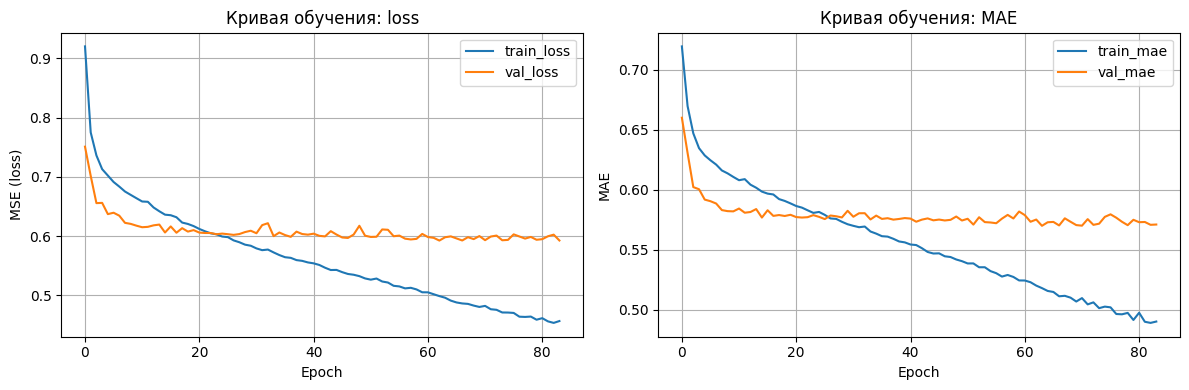

In [42]:
# Кривые обучения модели, уже есть result = create_and_train_best_model(..), в нём лежит history.

history = result['history']
hist = history.history

plt.figure(figsize=(12, 4))

# 1) Loss (MSE)
plt.subplot(1, 2, 1)
plt.plot(hist['loss'], label='train_loss')
plt.plot(hist['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('MSE (loss)')
plt.title('Кривая обучения: loss')
plt.legend()
plt.grid(True)

# 2) MAE
plt.subplot(1, 2, 2)
plt.plot(hist['mae'], label='train_mae')
plt.plot(hist['val_mae'], label='val_mae')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Кривая обучения: MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
Нет признаков переобучения,потому что Кривая val_loss (оранжевая) не растёт после определённого момента. т.е. стабилизируется , train_loss (синяя) ниже val_loss, но разница между ними небольшая и стабильная — это нормально для регрессии.
Если бы была переобученность, val_loss начала бы расти, а train_loss продолжала бы падать — этого не наблюдается.
Можно сделать вывод, что модель обобщает хорошо, переобучения нет.
Динамика кривых обучения по MAE фактически повторяет по loss, соотвественно, можно сделать вывод, что модель обобщает хорошо, переобучения нет.

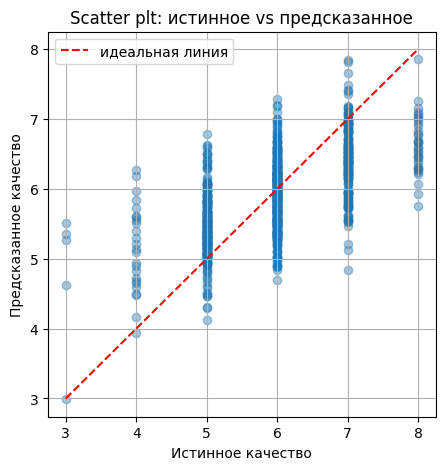

In [43]:
y_true = result['y_test_real']
y_pred = result['y_pred']

plt.figure(figsize=(5, 5))
plt.scatter(y_true, y_pred, alpha=0.4)
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         'r--', label='идеальная линия')
plt.xlabel('Истинное качество')
plt.ylabel('Предсказанное качество')
plt.title('Scatter plt: истинное vs предсказанное')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
Точки группируются вдоль красной диагонали, особенно в центре (качество 5–7). и хотя R² далеко не 1, но модель явно лучше банального среднего
Это говорит о том, что модель в целом  улавливает зависимость, хотя мы видим, что она часто завышает качество плохого и среднего вина.

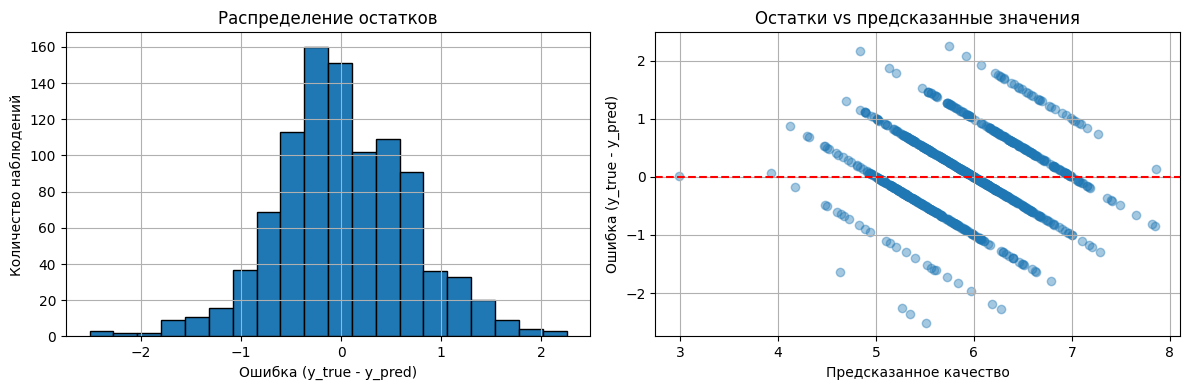

In [44]:
residuals = y_true - y_pred  

plt.figure(figsize=(12, 4))

# 1) Гистограмма остатков
plt.subplot(1, 2, 1)
plt.hist(residuals, bins=20, edgecolor='k')
plt.xlabel('Ошибка (y_true - y_pred)')
plt.ylabel('Количество наблюдений')
plt.title('Распределение остатков')
plt.grid(True)

# 2) Остатки vs предсказания
plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals, alpha=0.4)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Предсказанное качество')
plt.ylabel('Ошибка (y_true - y_pred)')
plt.title('Остатки vs предсказанные значения')
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
Модель не имеет систематического смещения, поскольку остатки центрированы вокруг нуля.
Распределение ошибок приближается к нормальному, что также хорошо для интерпретации модели.
Основная масса ошибок находится в пределах +/-1 балла, что соответствует MAE ≈ 0.5.
Небольшая асимметрия влево подтверждает, что модель часто завышает качество плохого вина (что мы видели и на scatter plot)

In [ ]:
Модель не имеет систематической ошибки, поскольку остатки не зависят от величины предсказания.
Дисперсия ошибки постоянна по всему диапазону, то есть нет гетероскедастичности.
Распределение точек хаотично и равномерно, что является признаком качества модели.